In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from sideinfo_release import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
fn = 'data/gtex_filtered3.csv'
dim = 2


data = np.loadtxt(open(fn, "rb"), delimiter=",", skiprows=1)
x = data[:,0:dim]
p = data[:,dim]
h = data[:,dim+1]
n_samples = len(x)



In [35]:

    
def get_network_new(num_layers = 10, node_size = 10, dim = 1, scale = 1, cuda = False):
    
    
    class Model(nn.Module):
        def __init__(self, num_layers, node_size, dim, scale):
            super(Model, self).__init__()
            l = []
            l.append(nn.Linear(dim,node_size))
            l.append(nn.LeakyReLU(0.1))
            for i in range(num_layers - 2):
                l.append(nn.Linear(node_size,node_size))
                l.append(nn.LeakyReLU(0.1))

            l.append(nn.Linear(node_size,1))
            
            self.scale = scale
            self.layers = nn.Sequential(*l)


        def forward(self, x):
            x = self.layers(x)
            x = torch.mul(torch.exp(x) , self.scale)
            
            return x


    network = Model(num_layers, node_size, dim, scale)
    if cuda:
        return network.cuda()
    else:
        return network    

In [36]:
max_x0 = np.max(x[:,0])
min_x0 = np.min(x[:,0])
max_x1 = np.max(x[:,1])
min_x1 = np.min(x[:,1])
x_prob0 = np.arange(min_x0, max_x0, (max_x0 - min_x0)/100.0)
x_prob1 = np.arange(min_x1, max_x1, (max_x1 - min_x1)/100.0)
X_grid, Y_grid = np.meshgrid(x_prob0, x_prob1)
x_prob = Variable(torch.from_numpy(
np.concatenate([[X_grid.flatten()], [Y_grid.flatten()]]).T.astype(np.float32)))
grids = (X_grid, Y_grid)

In [43]:
network = get_network_new(cuda = True, dim = 2, scale = 0.00027629599999999999)

In [44]:
network.load_state_dict(torch.load('data/gtex2d.th'))

In [45]:
output = network(x_prob.cuda())

In [46]:
output_np = output.cpu().data.numpy().reshape(100,100)

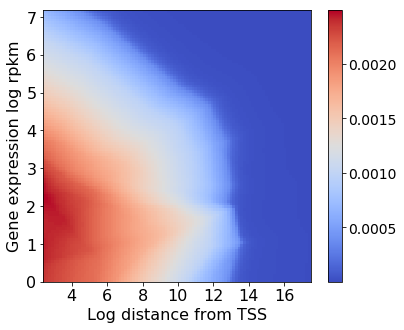

In [48]:
plt.figure(figsize = (6,5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Log distance from TSS', fontsize=16)
plt.ylabel('Gene expression log rpkm', fontsize=16)
plt.pcolor(X_grid, Y_grid, output_np , cmap = 'coolwarm')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.savefig('2dgtex.png', dpi=300, pad_inches=1, bbox_inches='tight')


In [17]:
import pickle as pkl
km = pkl.load(open('data/gtexkm.pkl'))

In [21]:
group = km.predict(x_prob.cpu().data.numpy())

In [24]:
weights = np.loadtxt('data/ihwgtex2dweights.csv', delimiter=',',  skiprows=1, usecols=(1,2,3,4,5))

In [27]:
w = weights.mean(axis = 1)

In [29]:
z = w[group].reshape(100,100)

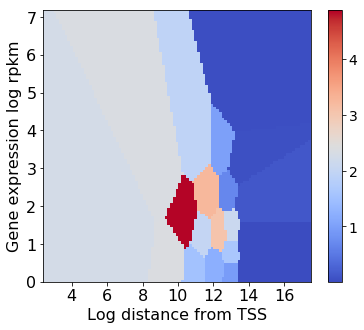

In [34]:
plt.figure(figsize = (6,5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Log distance from TSS', fontsize=16)
plt.ylabel('Gene expression log rpkm', fontsize=16)
plt.pcolor(X_grid, Y_grid, z, cmap = 'coolwarm')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.savefig('2dgtex_ihw.png', dpi=300, pad_inches=1, bbox_inches='tight')

